In [3]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_style("darkgrid")
import scipy
from scipy import stats
from scipy import signal
sns.plt = plt
np.random.seed(1) # No estoy seguro si es necesario

mail = """
Hola a todos

Varios me preguntaron del formato de los archivos .mat

Cada .mat corresponde a un paciente y contiene una matriz tridimensional: trials/epochs x electrodos x muestras en Epoch

Por ejemplo, El archivo P01 tiene 864 epochs (primer dimensión). Eso quiere decir que de los 1200 ensayos que se hicieron con ese paciente solo 864 sobrevivieron al filtrado y preprocesamiento.

Espero que esto aclare un poco...


"""


In [19]:
# Carga de datos
# Tarda bocha

datasets_normales = []
datasets_disminuidos = []
for i in range(1,9):
    datasets_normales.append(scipy.io.loadmat('datos/S0'+str(i)+'.mat')['data'])
    datasets_disminuidos.append(scipy.io.loadmat('datos/P0'+str(i)+'.mat')['data'])
datasets_normales.append(scipy.io.loadmat('datos/S10.mat')['data'])
datasets_disminuidos.append(scipy.io.loadmat('datos/P10.mat')['data'])


[ -4.35408691e-06  -4.44285234e-06  -4.90411312e-06  -5.79617042e-06
  -5.23054256e-06  -1.90430861e-06   2.42968741e-06   4.23015408e-06
   2.12478897e-06  -1.26759959e-06  -2.17113167e-06   8.61145203e-08
   2.50241212e-06   2.11582144e-06  -6.63450113e-07  -3.07377920e-06
  -3.70557954e-06  -3.96773713e-06  -5.60806525e-06  -7.83197099e-06
  -7.95915316e-06  -4.78997803e-06  -3.28458310e-07   2.29484985e-06
   2.06419112e-06   6.60672435e-07   1.12136933e-07   6.55586852e-07
   1.13951024e-06   8.90754426e-07   4.91596811e-07   7.46029844e-07
   1.43588898e-06   1.46579393e-06   1.54603259e-07  -1.83276273e-06
  -2.91470770e-06  -1.97689597e-06   5.87990635e-07   3.18952059e-06
   4.47722330e-06   4.51860478e-06   4.44869287e-06   4.93633384e-06
   5.29450365e-06   4.44446014e-06   2.61747799e-06   1.51337654e-06
   2.43651519e-06   4.63225332e-06   6.02579731e-06   5.57088679e-06
   4.30144163e-06   3.84462523e-06   4.43992815e-06   5.00155331e-06
   4.86624320e-06   4.64759501e-06

AttributeError: 'list' object has no attribute 'shape'

In [103]:
# Epochs = 657
# Electrodos = 256
# Tiempos = 201
# Epochs x Electrodos  x Tiempo
print datasets_normales[0][0][0][0]
print np.shape(datasets_normales[0])
print datasets_disminuidos[0][0][0][0]
print np.shape(datasets_disminuidos[0])

-4.35408691359e-06
(657, 256, 201)
9.5019053032e-06
(894, 256, 201)


In [5]:
# a) Computar uno de los posibles análisis espectrales.

# a.1) Calcular la media entre los electrodos 8, 44, 80, 131 y 185 (el primer electrodo es el 0) 
# y realizar una figura que muestre las frecuencias en el eje Y, los epochs en el eje X,
# y la potencia usando una escala de color como en el ejemplo:

In [109]:
def electrodos_usados(dataset):
    electrodo8 = dataset[:, 7, :]
    electrodo44 = dataset[:, 43, :]
    electrodo80 = dataset[:, 79, :]
    electrodo131 = dataset[:, 130, :]
    electrodo185 = dataset[:, 184, :]
    return [electrodo8, electrodo44, electrodo80, electrodo131, electrodo185]

# Matriz de (Sujeto x Electrodo x Epoch x Tiempo -> Valor)
electrodos_usados_todos = ([electrodos_usados(datasets_normales[i]) for i in range(len(datasets_normales))] + 
                     [electrodos_usados(datasets_disminuidos[i]) for i in range(len(datasets_disminuidos))])

print len(electrodos_usados_todos)
print np.shape(electrodos_usados_todos[0])

18
(5, 657, 201)


In [123]:
# Dada una lista de (Sujeto x Electrodo x Epoch x Tiempo -> Valor) y un Epoch, promedia los tiempos del Epoch
# y devuelve la lista (Tiempo -> Valor) promediando sujetos y electrodos en el epoch
def average_time_series(datasets, epoch):
    ans = []
    for t in range(len(datasets[0][0][epoch])):
        tmp = []
        for s in range(len(datasets)):
            for e in range(len(datasets[s])):
                if epoch < len(datasets[s][e]):
                    tmp.append(datasets[s][e][epoch][t])
        ans.append(np.mean(tmp))
    return ans

# Dado un epoch y una matriz de (Sujeto x Electrodo x Epoch x Tiempo -> Valor)
# devolver una lista de (Epoch x Tiempo -> Valor) promediando
def average_by_epoch(datasets):
    return [average_time_series(datasets, epoch) for epoch in range(len(datasets[0][0])) ]

In [124]:
averaged_by_epoch = average_by_epoch(electrodos_usados_todos)
print averaged_by_epoch[0][0]
# Primer Epoch

def freq_pots_relevantes(freqs, pots):
    pairs_relevantes = filter(lambda x: x[0] <= 45.0, zip(freqs, pots))
    freqs_relevantes = map(lambda x: x[0], pairs_relevantes)
    amplitudes_relevantes = map(lambda x: x[1], pairs_relevantes)
    return (freqs_relevantes, amplitudes_relevantes)
    
allEpochs = pd.DataFrame();
for i in range(len(averaged_by_epoch)):
    epoch_welch = scipy.signal.welch(averaged_by_epoch[i], fs=250)
    frecuencas_sampleadas = epoch_welch[0]; # Deberia ser siempre lo mismo
    (freqs_relevantes, pots_relevantes) = freq_pots_relevantes(frecuencas_sampleadas, epoch_welch[1])
    allEpochs = allEpochs.append(pd.DataFrame(pots_relevantes).transpose());
allEpochs = allEpochs.reset_index();


# No se por que aparece mil veces el dataframe printeado
# Arreglar eso
# crei que los ';' lo arreglaban pero no

-7.09855278858e-08


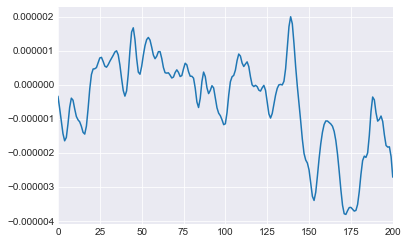

In [125]:
# Viendo este grafico creo que habia que suavizar la funcion
# Capaz asi el grafico de arriba se pone mas interesante

sns.tsplot(averaged_by_epoch[20])
plt.show()

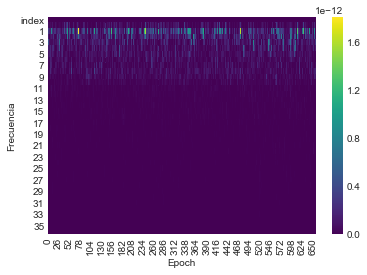

In [133]:
ax = sns.heatmap(allEpochs.transpose(), cmap="viridis" )

ax.set_ylabel('Frecuencia')
ax.set_xlabel('Epoch')
_, labels = plt.yticks()
plt.setp(labels, rotation=0)

plt.show()

In [57]:
def get_epoch(epoch_idx,electrodo_idx, dataset):
    return dataset[epoch_idx, electrodo_idx, :]

def par_frecuencias_potencias_epoch(epoch_idx,electrodo_idx,dataset):
    welch_result = scipy.signal.welch(get_epoch(epoch_idx,electrodo_idx,dataset), fs=250)
    return freq_pots_relevantes(welch_result[0], welch_result[1])

# Dado un dataset y un electrodo devuelve una lista de potencias promedio para cada epoch
def potencias_promedio(electrodo_idx,dataset):
    potencias = [par_frecuencias_potencias_epoch(i,electrodo_idx, dataset) for i in range(894)][1]
    res = []
    for i in range(len(potencias[0])):
        res.append(np.average([pot[i] for pot in potencias]))
    return res

In [58]:
colors = sns.color_palette("muted", n_colors=201)

def get_potencias_datasets(datasets):
    potencias_datasets = []
    for i in range(len(datasets)):
        potencias_datasets.append([])
        for j in range(200):
            potencias_datasets[i].append(potencias_promedio(j, datasets[i]))
    return potencias_datasets

# potencias_normales = get_potencias_datasets(datasets_normales)
potencias_disminuidas = get_potencias_datasets(datasets_disminuidos[0:1])


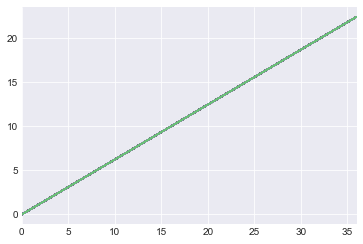

In [59]:
for i in range(200):
    sns.tsplot(potencias_disminuidas[0][i], color=colors[i])
plt.show()

In [60]:

potencias_promedio = [np.average([pot[i] for pot in potencias_disminuidas[0] ]) for i in range(len(potencias_disminuidas[0][0]))]

In [61]:
print potencias_promedio

[1.7508723817815008e-13, 0.62189054726473525, 1.2437810945283028, 1.8656716417918988, 2.4875621890551103, 3.1094527363187647, 3.7313432835825493, 4.3532338308461851, 4.97512437810982, 5.5970149253734531, 6.2189054726373421, 6.8407960199009326, 7.462686567164468, 8.0845771144281677, 8.7064676616919936, 9.3283582089555299, 9.9502487562190929, 10.572139303482786, 11.194029850746597, 11.815920398010416, 12.437810945274924, 13.059701492538743, 13.681592039801931, 14.303482587065268, 14.925373134329007, 15.547263681592408, 16.169154228856325, 16.791044776119762, 17.412935323383504, 18.034825870647381, 18.656716417910861, 19.27860696517466, 19.900497512438307, 20.522388059701871, 21.144278606965671, 21.766169154229217, 22.388059701492743]


In [15]:
def potencia_banda(low, high, potencias_promedio, frecuencias):
    # Thomas dice np.average
    return np.average(map(lambda x: x[0], filter(lambda x: x[1] >= low and x[1] < high, zip(potencias_promedio, frecuencias))))

In [16]:
banda_delta = potencia_banda(0., 4.0)
banda_theta = potencia_banda(4.0, 8.0)
banda_alpha = potencia_banda(8.0, 13.0)
banda_beta = potencia_banda(13.0, 30.)
banda_gamma = potencia_banda(30.0, 125.)
print banda_delta
print banda_theta
print banda_alpha
print banda_beta
print banda_gamma

6.57555347385e-12
1.24802811046e-12
4.4738889361e-13
1.93761324456e-13
1.52663267528e-13


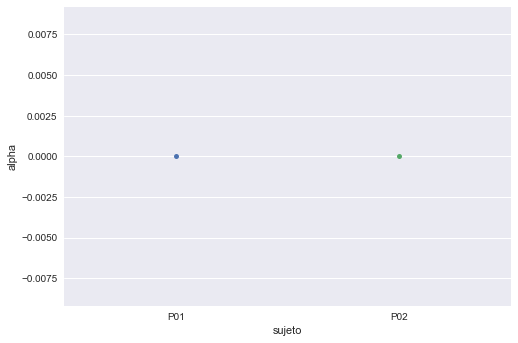

In [23]:
alpha_frame = pd.DataFrame(data=[{"alpha":banda_alpha,"sujeto":"P01"}, {"alpha":banda_alpha+1e-13,"sujeto":"P02"}], columns=['alpha','sujeto'])
sns.stripplot(data=alpha_frame, y="alpha", x="sujeto")

plt.show()

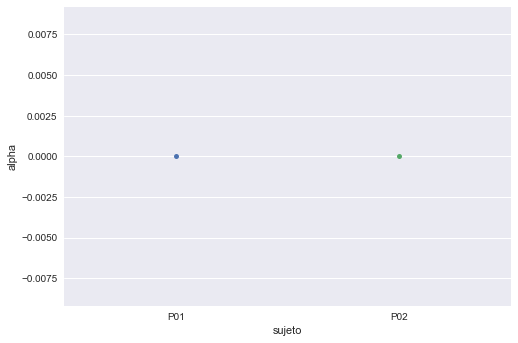

In [24]:
sns.swarmplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

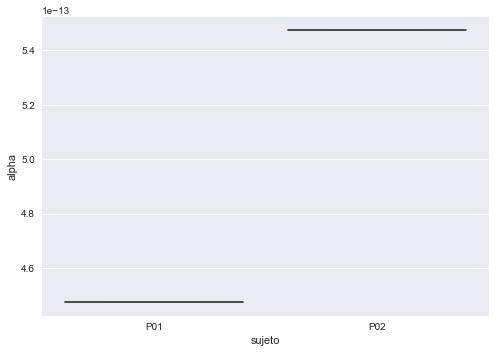

In [25]:
sns.boxplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

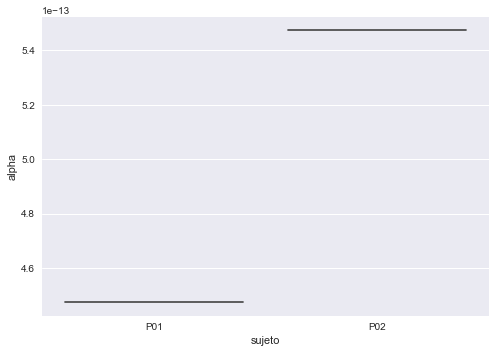

In [26]:
sns.violinplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

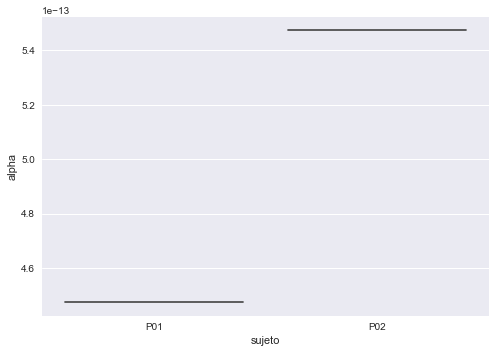

In [27]:
sns.lvplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

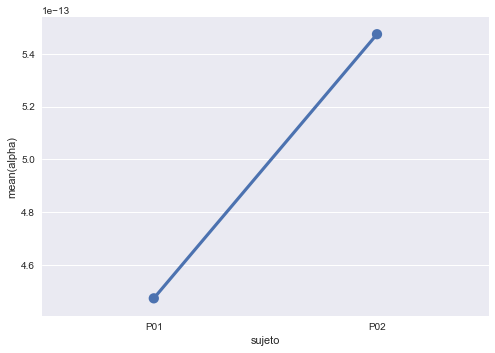

In [28]:
sns.pointplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

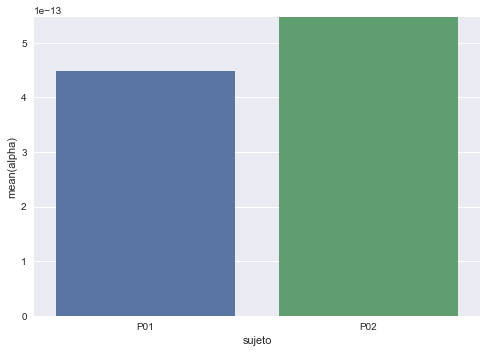

In [32]:
sns.barplot(x="sujeto", y="alpha", data=alpha_frame)
plt.show()

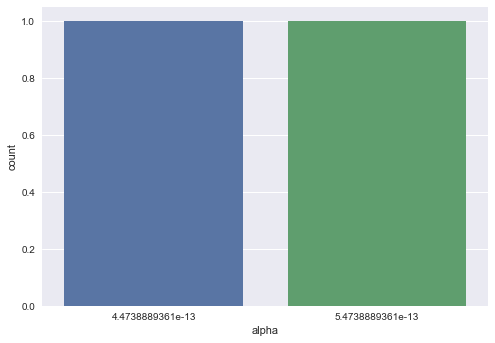

In [36]:
sns.countplot(x="alpha", data=alpha_frame)
plt.show()